# Plotting the overpotential map

## 1. Importing libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern, ConstantKernel, ExpSineSquared, RBF, RationalQuadratic
from scipy.optimize import minimize
from sklearn import preprocessing
from scipy.stats import norm
import random
import time
import math

## 2. Loading dataset

In [6]:
# Load the spreadsheet
file_path = 'Entropy-screened BO dataset.csv'
data = pd.read_csv(file_path)
# Display the first few rows of the dataframe to understand its structure
data.head()

,Mn,Fe,Co,Ni,Cu,Mo,OWS overpotential
0,90.0,0.0,0.0,0.0,0.0,0.0,747
1,0.0,90.0,0.0,0.0,0.0,0.0,540
2,0.0,0.0,90.0,0.0,0.0,0.0,515
3,0.0,0.0,0.0,90.0,0.0,0.0,500
4,0.0,0.0,0.0,0.0,90.0,0.0,669


In [7]:
# Renaming columns for clarity
data.columns = ['Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Mo', 'Objective']

# Splitting the data into inputs (X) and output (y)
X = data[['Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Mo']].values
y = data['Objective'].values
X = X/90

## 3. Model fitting

In [9]:
#fitting
kernel = 1.0 * Matern(nu=1.5) 
gp = GaussianProcessRegressor(kernel=kernel, alpha = 0.15, n_restarts_optimizer=1000, normalize_y = True)
gp.fit(X, y)
gp.kernel_

1.02**2 * Matern(length_scale=0.192, nu=1.5)

## 4. Search point generation

In [11]:
def generate_constrained_points(variable_index, n_points):
    x_points = np.linspace(0, 1, n_points)
    points = np.zeros((n_points, 6))

    for i in range(n_points):
        x = x_points[i]
        points[i, variable_index] = x

        candidates = []
        random_numbers = [random.randint(1, n_points) for _ in range(5)]
        total = sum(random_numbers)
        results = [round((1-x)*number / total, 4) for number in random_numbers] #randomly generate 6 numbers with boundary
        candidates.append(results)
        # # allocate array
        selected_candidate = candidates[0]
        
        candidate_index = 0
        for j in range(6):
            if j != variable_index:
                points[i, j] = selected_candidate[candidate_index]
                candidate_index += 1          
    return points

In [12]:
def average_predictions(gp, variable_index, n_points, n_iterations=10000):
    total_y_pred = 0
    total_sigma = 0
    pointsarray = []
    for _ in range(n_iterations):
        points = generate_constrained_points(variable_index, n_points)
        pointsarray.append(points)
        y_pred, sigma = gp.predict(points, return_std=True)

        total_y_pred += y_pred
        total_sigma += sigma

    # calculation of average
    average_y_pred = total_y_pred / n_iterations
    average_sigma = total_sigma / n_iterations
    
    for i in range(n_iterations-1):
    # concatenate pointsarray[i] to result_array
        result_array = np.concatenate((pointsarray[i], pointsarray[i+1]), axis=0)

    return average_y_pred, average_sigma, result_array

In [13]:
def find_uncertainty_by_line(gp, n_points):
    variable_index=[0,1,2,3,4,5]
    y_pred_list=[]
    sigma_list=[]
    array_list=[]
    for i in range(len(variable_index)):
        y_pred, sigma, array = average_predictions(gp, variable_index[i], n_points)
        y_pred_list.append(y_pred)
        sigma_list.append(sigma)
        array_list.append(array)
    return y_pred_list, sigma_list, array_list

## 5. Prediction (running this cell may take few minutes)

In [15]:
n_points = 91  # number of points to generate

start_time = time.time()  # check time

y_pred, sigma, array = find_uncertainty_by_line(gp, n_points)

end_time = time.time()
total = end_time - start_time
print("prediction time :", total) 

prediction time : 71.72853469848633


## 6. Plotting overpotential maps

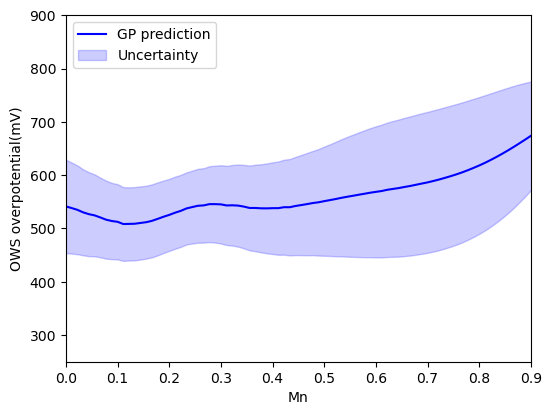

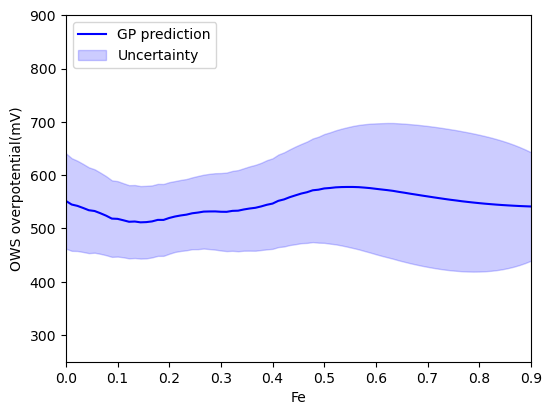

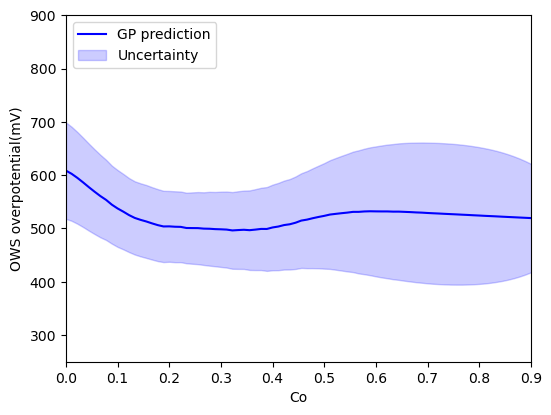

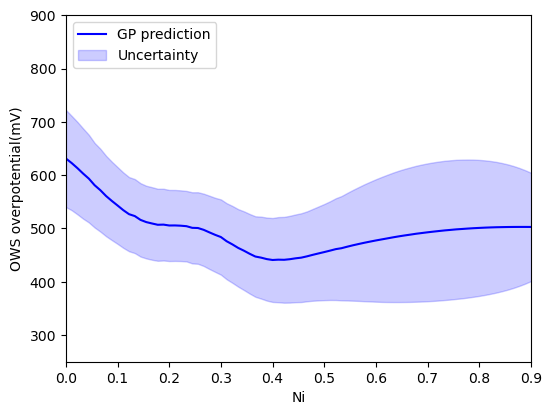

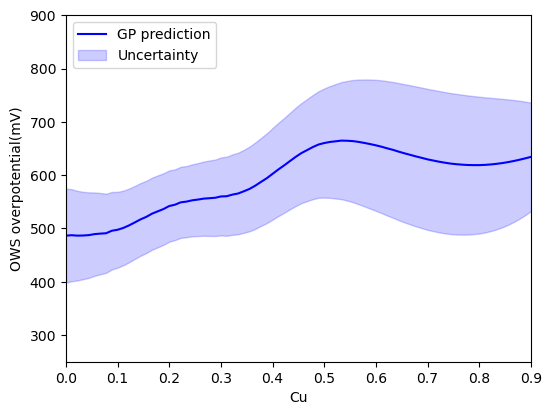

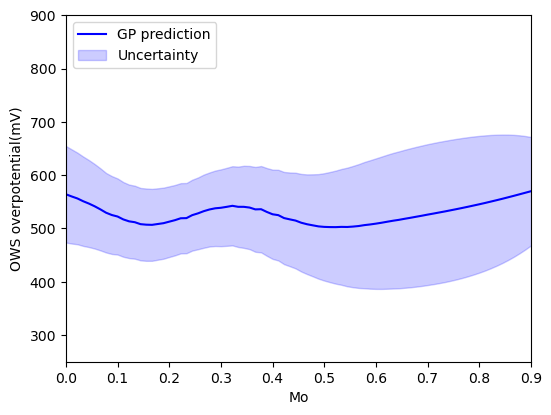

In [17]:
# Plotting
for variable_index in range(6):
    plt.figure(figsize=(6, 4.5))
    plt.plot(array[variable_index][:n_points, variable_index], y_pred[variable_index],'b-',label = 'GP prediction')
    plt.fill_between(array[variable_index][:n_points, variable_index], y_pred[variable_index] - sigma[variable_index], y_pred[variable_index] + sigma[variable_index], alpha=0.2, color='blue', label = 'Uncertainty')
    plt.xlabel(f'{data.columns[variable_index]}')
    plt.ylabel('OWS overpotential(mV)')
    plt.xlim(0,0.9)
    plt.ylim(250,900)
    plt.legend(loc='upper left')
    plt.show()